# 05 - Islamic NER Training (Silver Data, AraBERT v02)

This notebook trains and compares two token-classification setups on the silver dataset:
- **Run A**: standard cross-entropy
- **Run B**: class-weighted cross-entropy

Both runs use the same tokenizer/model backbone and the same subword alignment strategy as the ANERCorp baseline.

## Why Two Training Runs? (Ablation Study)

We run two experiments to isolate the impact of **class weighting** under strong label imbalance.

- Run A gives the reference behavior with no weighting.
- Run B increases the loss contribution of rare classes (BOOK, HADITH_REF, some I- tags).

Class weights can improve recall for rare entities by penalizing mistakes on those classes more heavily.
Given this silver distribution, expect **SCHOLAR** to be strongest, while **BOOK/HADITH_REF** may stay weaker due to very low support.

In [1]:
from __future__ import annotations

import importlib
import inspect
import json
import random
import subprocess
import sys
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple


def ensure_package(import_name: str, pip_name: str | None = None) -> None:
    try:
        importlib.import_module(import_name)
        return
    except ImportError:
        pkg = pip_name or import_name
        print(f"Installing missing package: {pkg} (python: {sys.executable})")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])


# Install into the active notebook kernel only if missing.
ensure_package("evaluate")
ensure_package("seqeval")
ensure_package("datasets")
ensure_package("transformers")
ensure_package("accelerate")
ensure_package("matplotlib")
ensure_package("pandas")
ensure_package("numpy")
ensure_package("torch")

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from torch import nn
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
)


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data").exists() and (candidate / "notebooks").exists():
            return candidate
    return start


ROOT = find_project_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Project root: {ROOT}")
print(f"Torch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


Project root: C:\Users\diaab\islamic-ner
Torch device: cpu


In [2]:
SILVER_TRAIN_PATH = ROOT / "data" / "silver" / "train.json"
SILVER_DEV_PATH = ROOT / "data" / "silver" / "dev.json"

model_name = "aubmindlab/bert-base-arabertv02"
MAX_SEQ_LENGTH = 128

labels = [
    "O",
    "B-SCHOLAR", "I-SCHOLAR",
    "B-BOOK", "I-BOOK",
    "B-CONCEPT", "I-CONCEPT",
    "B-PLACE", "I-PLACE",
    "B-HADITH_REF", "I-HADITH_REF",
]

label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

print("Train path:", SILVER_TRAIN_PATH)
print("Dev path:", SILVER_DEV_PATH)
print("Model:", model_name)
print("MAX_SEQ_LENGTH:", MAX_SEQ_LENGTH)
print("Label mapping:", label2id)


Train path: C:\Users\diaab\islamic-ner\data\silver\train.json
Dev path: C:\Users\diaab\islamic-ner\data\silver\dev.json
Model: aubmindlab/bert-base-arabertv02
MAX_SEQ_LENGTH: 128
Label mapping: {'O': 0, 'B-SCHOLAR': 1, 'I-SCHOLAR': 2, 'B-BOOK': 3, 'I-BOOK': 4, 'B-CONCEPT': 5, 'I-CONCEPT': 6, 'B-PLACE': 7, 'I-PLACE': 8, 'B-HADITH_REF': 9, 'I-HADITH_REF': 10}


## Tokenization Note (AraBERT Preprocessing)

AraBERT v02 can benefit from `ArabertPreprocessor` pre-segmentation.
For this notebook, we intentionally **skip preprocessing** and use the raw tokenizer input so we can measure it later as a separate ablation.

In [3]:
def load_silver_split(path: Path) -> Dataset:
    records = json.loads(path.read_text(encoding="utf-8"))
    cleaned = []
    for i, record in enumerate(records):
        tokens = record.get("tokens") or []
        tags = record.get("ner_tags") or []
        if not isinstance(tokens, list) or not isinstance(tags, list):
            continue
        n = min(len(tokens), len(tags))
        if n == 0:
            continue
        cleaned.append(
            {
                "id": record.get("id", f"{path.stem}_{i}"),
                "tokens": tokens[:n],
                "ner_tags": tags[:n],
            }
        )
    return Dataset.from_list(cleaned)


dataset_dict = DatasetDict(
    {
        "train": load_silver_split(SILVER_TRAIN_PATH),
        "dev": load_silver_split(SILVER_DEV_PATH),
    }
)
print(dataset_dict)


def count_labels(split_dataset: Dataset) -> Counter:
    counts = Counter()
    for row in split_dataset:
        counts.update(row["ner_tags"])
    return counts


train_counts = count_labels(dataset_dict["train"])
dev_counts = count_labels(dataset_dict["dev"])

unknown_train = sorted(set(train_counts) - set(labels))
unknown_dev = sorted(set(dev_counts) - set(labels))
assert not unknown_train, f"Unknown labels in train: {unknown_train}"
assert not unknown_dev, f"Unknown labels in dev: {unknown_dev}"

dist_df = pd.DataFrame({
    "label": labels,
    "train_count": [train_counts.get(lbl, 0) for lbl in labels],
    "dev_count": [dev_counts.get(lbl, 0) for lbl in labels],
})
dist_df


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2969
    })
    dev: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 360
    })
})


,label,train_count,dev_count
0,O,125158,15583
1,B-SCHOLAR,14053,1763
2,I-SCHOLAR,20228,2411
3,B-BOOK,50,0
4,I-BOOK,51,0
5,B-CONCEPT,767,92
6,I-CONCEPT,6,0
7,B-PLACE,356,55
8,I-PLACE,8,6
9,B-HADITH_REF,75,0


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_and_align_labels(examples: Dict[str, List[List[str]]]) -> Dict[str, List[List[int]]]:
    tokenized = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=MAX_SEQ_LENGTH,
    )

    aligned_labels = []
    for i, word_level_tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword keeps the original word label.
                label_ids.append(label2id[word_level_tags[word_idx]])
            else:
                # Non-first subwords are ignored in the loss/metrics.
                label_ids.append(-100)
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)

    tokenized["labels"] = aligned_labels
    return tokenized


tokenized_datasets = dataset_dict.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_dict["train"].column_names,
    desc="Tokenize + align labels",
)
tokenized_datasets


Tokenize + align labels:   0%|          | 0/2969 [00:00<?, ? examples/s]

Tokenize + align labels:   0%|          | 0/360 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2969
    })
    dev: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 360
    })
})

In [5]:
seqeval_metric = evaluate.load("seqeval")


def decode_predictions(pred_ids: np.ndarray, label_ids: np.ndarray) -> Tuple[List[List[str]], List[List[str]]]:
    y_true: List[List[str]] = []
    y_pred: List[List[str]] = []

    for pred_row, label_row in zip(pred_ids, label_ids):
        row_true: List[str] = []
        row_pred: List[str] = []
        for pred_id, label_id in zip(pred_row, label_row):
            if int(label_id) == -100:
                continue
            row_true.append(id2label[int(label_id)])
            row_pred.append(id2label[int(pred_id)])
        y_true.append(row_true)
        y_pred.append(row_pred)

    return y_true, y_pred


def compute_metrics(eval_pred) -> Dict[str, float]:
    logits, labels_arr = eval_pred
    pred_ids = np.argmax(logits, axis=2)
    y_true, y_pred = decode_predictions(pred_ids, labels_arr)

    scores = seqeval_metric.compute(predictions=y_pred, references=y_true)
    return {
        "precision": float(scores["overall_precision"]),
        "recall": float(scores["overall_recall"]),
        "f1": float(scores["overall_f1"]),
        "accuracy": float(scores["overall_accuracy"]),
    }


def evaluate_and_print(trainer: Trainer, dataset, run_name: str):
    pred_output = trainer.predict(dataset)
    pred_ids = np.argmax(pred_output.predictions, axis=2)
    y_true, y_pred = decode_predictions(pred_ids, pred_output.label_ids)

    overall = {
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    report_text = classification_report(y_true, y_pred, digits=4)
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    print(f"[{run_name}] Overall Precision: {overall['precision']:.4f}")
    print(f"[{run_name}] Overall Recall:    {overall['recall']:.4f}")
    print(f"[{run_name}] Overall F1:        {overall['f1']:.4f}\n")
    print(report_text)

    return overall, report_dict, pred_output


def plot_training_loss(trainer: Trainer, run_name: str) -> pd.DataFrame:
    loss_rows = []
    for row in trainer.state.log_history:
        if "loss" in row and "eval_loss" not in row and "epoch" in row:
            loss_rows.append({"epoch": float(row["epoch"]), "loss": float(row["loss"])})

    if not loss_rows:
        print(f"No training loss logs found for {run_name}.")
        return pd.DataFrame(columns=["epoch", "loss"])

    loss_df = pd.DataFrame(loss_rows).sort_values("epoch")
    plt.figure(figsize=(7, 4))
    plt.plot(loss_df["epoch"], loss_df["loss"], marker="o")
    plt.title(f"Training Loss Curve - {run_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.grid(alpha=0.3)
    plt.show()

    return loss_df


In [7]:
RUN_A_DIR = ROOT / "models" / "islamic_ner_standard"
RUN_B_DIR = ROOT / "models" / "islamic_ner_weighted"
RUN_A_DIR.mkdir(parents=True, exist_ok=True)
RUN_B_DIR.mkdir(parents=True, exist_ok=True)


def make_training_args(output_dir: Path) -> TrainingArguments:
    kwargs = {
        "output_dir": str(output_dir),
        "num_train_epochs": 5,
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 16,
        "learning_rate": 3e-5,
        "weight_decay": 0.01,
        "save_strategy": "epoch",
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "logging_steps": 25,
        "seed": SEED,
        "report_to": "none",
    }

    # Transformers renamed evaluation_strategy -> eval_strategy in newer releases.
    signature = inspect.signature(TrainingArguments.__init__)
    if "eval_strategy" in signature.parameters:
        kwargs["eval_strategy"] = "epoch"
    else:
        kwargs["evaluation_strategy"] = "epoch"

    return TrainingArguments(**kwargs)


def init_model():
    return AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


## Class Weights

For Run B, class weights are computed from train-token frequencies:

`weight_i = total_tokens / (num_classes * count_i)`

Then all weights are normalized so the `O` class is near `1.0`.
This keeps weighting interpretable while upweighting rare entity classes.

In [7]:
train_label_counts = Counter()
for row in dataset_dict["train"]:
    train_label_counts.update(row["ner_tags"])

total_tokens = sum(train_label_counts.get(label, 0) for label in labels)
num_classes = len(labels)

raw_weights = {}
for label in labels:
    count_i = train_label_counts.get(label, 0)
    if count_i == 0:
        raw_weights[label] = 0.0
    else:
        raw_weights[label] = total_tokens / (num_classes * count_i)

o_weight = raw_weights.get("O", 1.0) or 1.0
normalized_weights = {
    label: (weight / o_weight if weight > 0 else 0.0)
    for label, weight in raw_weights.items()
}

class_weights_tensor = torch.tensor([normalized_weights[label] for label in labels], dtype=torch.float)

weights_df = pd.DataFrame(
    {
        "label": labels,
        "count": [train_label_counts.get(label, 0) for label in labels],
        "raw_weight": [raw_weights[label] for label in labels],
        "normalized_weight": [normalized_weights[label] for label in labels],
    }
)
weights_df


,label,count,raw_weight,normalized_weight
0,O,125158,0.116895,1.000000
1,B-SCHOLAR,14053,1.041085,8.906141
2,I-SCHOLAR,20228,0.723273,6.187364
3,B-BOOK,50,292.607273,2503.160000
4,I-BOOK,51,286.869875,2454.078431
5,B-CONCEPT,767,19.074790,163.178618
6,I-CONCEPT,6,2438.393939,20859.666667
7,B-PLACE,356,41.096527,351.567416
8,I-PLACE,8,1828.795455,15644.750000
9,B-HADITH_REF,75,195.071515,1668.773333


## Run A: Standard Cross-Entropy

In [8]:
model_a = init_model()
training_args_a = make_training_args(RUN_A_DIR)

trainer_a = Trainer(
    model=model_a,
    args=training_args_a,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result_a = trainer_a.train()
eval_result_a = trainer_a.evaluate(tokenized_datasets["dev"])
print("Run A train metrics:", train_result_a.metrics)
print("Run A eval metrics:", eval_result_a)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/930 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 

In [9]:
overall_a, report_a, pred_output_a = evaluate_and_print(
    trainer_a, tokenized_datasets["dev"], "Run A - Standard"
)
loss_curve_a = plot_training_loss(trainer_a, "Run A - Standard")

run_a_final_dir = RUN_A_DIR / "final_model"
run_a_final_dir.mkdir(parents=True, exist_ok=True)
trainer_a.save_model(str(run_a_final_dir))
tokenizer.save_pretrained(str(run_a_final_dir))

(RUN_A_DIR / "dev_overall_metrics.json").write_text(
    json.dumps(overall_a, indent=2, ensure_ascii=False),
    encoding="utf-8",
)
(RUN_A_DIR / "dev_classification_report.json").write_text(
    json.dumps(report_a, indent=2, ensure_ascii=False),
    encoding="utf-8",
)
if not loss_curve_a.empty:
    loss_curve_a.to_csv(RUN_A_DIR / "training_loss_curve.csv", index=False)

print(f"Saved Run A model and metrics under: {RUN_A_DIR}")


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Run A - Standard] Overall Precision: 0.0014
[Run A - Standard] Overall Recall:    0.0058
[Run A - Standard] Overall F1:        0.0022

              precision    recall  f1-score   support

        BOOK     0.0000    0.0000    0.0000         0
     CONCEPT     0.0011    0.0326    0.0021        92
  HADITH_REF     0.0000    0.0000    0.0000         0
       PLACE     0.0014    0.0556    0.0027        54
     SCHOLAR     0.0051    0.0029    0.0037      1749

   micro avg     0.0014    0.0058    0.0022      1895
   macro avg     0.0015    0.0182    0.0017      1895
weighted avg     0.0048    0.0058    0.0036      1895

No training loss logs found for Run A - Standard.


TypeError: Object of type int32 is not JSON serializable

## Run B: Class-Weighted Cross-Entropy

In [11]:
if "class_weights_tensor" not in globals():
    train_label_counts = Counter()
    for row in dataset_dict["train"]:
        train_label_counts.update(row["ner_tags"])

    total_tokens = sum(train_label_counts.get(label, 0) for label in labels)
    num_classes = len(labels)
    raw_weights = {
        label: (total_tokens / (num_classes * train_label_counts.get(label, 1)))
        if train_label_counts.get(label, 0) > 0 else 0.0
        for label in labels
    }
    o_weight = raw_weights.get("O", 1.0) or 1.0
    normalized_weights = {
        label: (weight / o_weight if weight > 0 else 0.0)
        for label, weight in raw_weights.items()
    }
    class_weights_tensor = torch.tensor(
        [normalized_weights[label] for label in labels],
        dtype=torch.float,
    )

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: torch.Tensor, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels_tensor = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device),
            ignore_index=-100,
        )
        loss = loss_fn(logits.view(-1, model.config.num_labels), labels_tensor.view(-1))
        if return_outputs:
            return loss, outputs
        return loss


model_b = init_model()
training_args_b = make_training_args(RUN_B_DIR)

trainer_b = WeightedTrainer(
    model=model_b,
    args=training_args_b,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
)

train_result_b = trainer_b.train()
eval_result_b = trainer_b.evaluate(tokenized_datasets["dev"])
print("Run B train metrics:", train_result_b.metrics)
print("Run B eval metrics:", eval_result_b)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/930 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'loss': 1.5913, 'grad_norm': 4.050981044769287, 'learning_rate': 2.9193548387096776e-05, 'epoch': 0.13}
{'loss': 1.2358, 'grad_norm': 3.8853511810302734, 'learning_rate': 2.8387096774193552e-05, 'epoch': 0.27}
{'loss': 0.9294, 'grad_norm': 5.556384086608887, 'learning_rate': 2.758064516129032e-05, 'epoch': 0.4}
{'loss': 0.6153, 'grad_norm': 7.997486114501953, 'learning_rate': 2.6774193548387097e-05, 'epoch': 0.54}
{'loss': 0.581, 'grad_norm': 10.126968383789062, 'learning_rate': 2.5967741935483872e-05, 'epoch': 0.67}
{'loss': 0.6282, 'grad_norm': 8.523314476013184, 'learning_rate': 2.5161290322580648e-05, 'epoch': 0.81}
{'loss': 0.2682, 'grad_norm': 1.8890446424484253, 'learning_rate': 2.4354838709677417e-05, 'epoch': 0.94}


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.12917840480804443, 'eval_precision': 0.6237809452363091, 'eval_recall': 0.8775725593667546, 'eval_f1': 0.7292260469195353, 'eval_accuracy': 0.917204902608961, 'eval_runtime': 32.0661, 'eval_samples_per_second': 11.227, 'eval_steps_per_second': 0.717, 'epoch': 1.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'loss': 0.2164, 'grad_norm': 11.489849090576172, 'learning_rate': 2.3548387096774193e-05, 'epoch': 1.08}
{'loss': 0.1272, 'grad_norm': 1.0407789945602417, 'learning_rate': 2.274193548387097e-05, 'epoch': 1.21}
{'loss': 0.2498, 'grad_norm': 1.3018063306808472, 'learning_rate': 2.1935483870967744e-05, 'epoch': 1.34}
{'loss': 0.3541, 'grad_norm': 1.7459803819656372, 'learning_rate': 2.1129032258064516e-05, 'epoch': 1.48}
{'loss': 0.1344, 'grad_norm': 4.631195545196533, 'learning_rate': 2.032258064516129e-05, 'epoch': 1.61}
{'loss': 0.0633, 'grad_norm': 2.5732500553131104, 'learning_rate': 1.9516129032258064e-05, 'epoch': 1.75}
{'loss': 0.2345, 'grad_norm': 0.9725518822669983, 'learning_rate': 1.870967741935484e-05, 'epoch': 1.88}


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.07385812699794769, 'eval_precision': 0.7029580936729664, 'eval_recall': 0.9029023746701847, 'eval_f1': 0.7904827904827905, 'eval_accuracy': 0.9415653765956364, 'eval_runtime': 42.1563, 'eval_samples_per_second': 8.54, 'eval_steps_per_second': 0.546, 'epoch': 2.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'loss': 0.376, 'grad_norm': 0.3282621204853058, 'learning_rate': 1.7903225806451616e-05, 'epoch': 2.02}
{'loss': 0.1313, 'grad_norm': 0.3646169602870941, 'learning_rate': 1.7096774193548388e-05, 'epoch': 2.15}
{'loss': 0.0882, 'grad_norm': 2.698906898498535, 'learning_rate': 1.629032258064516e-05, 'epoch': 2.28}
{'loss': 0.0785, 'grad_norm': 1.114035725593567, 'learning_rate': 1.5483870967741936e-05, 'epoch': 2.42}
{'loss': 0.0463, 'grad_norm': 0.7898567914962769, 'learning_rate': 1.467741935483871e-05, 'epoch': 2.55}
{'loss': 0.0398, 'grad_norm': 0.4270433187484741, 'learning_rate': 1.3870967741935484e-05, 'epoch': 2.69}
{'loss': 0.0462, 'grad_norm': 11.269672393798828, 'learning_rate': 1.3064516129032258e-05, 'epoch': 2.82}
{'loss': 0.1242, 'grad_norm': 0.25987058877944946, 'learning_rate': 1.2258064516129034e-05, 'epoch': 2.96}


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.05719820782542229, 'eval_precision': 0.8046620046620047, 'eval_recall': 0.9108179419525066, 'eval_f1': 0.8544554455445544, 'eval_accuracy': 0.9637898591262778, 'eval_runtime': 21.4457, 'eval_samples_per_second': 16.787, 'eval_steps_per_second': 1.072, 'epoch': 3.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'loss': 0.0932, 'grad_norm': 1.0977059602737427, 'learning_rate': 1.1451612903225806e-05, 'epoch': 3.09}
{'loss': 0.0394, 'grad_norm': 0.4885452389717102, 'learning_rate': 1.0645161290322582e-05, 'epoch': 3.23}
{'loss': 0.0258, 'grad_norm': 1.8905702829360962, 'learning_rate': 9.838709677419354e-06, 'epoch': 3.36}
{'loss': 0.051, 'grad_norm': 0.2755037546157837, 'learning_rate': 9.03225806451613e-06, 'epoch': 3.49}
{'loss': 0.0307, 'grad_norm': 0.2997608780860901, 'learning_rate': 8.225806451612904e-06, 'epoch': 3.63}
{'loss': 0.0402, 'grad_norm': 0.2557797133922577, 'learning_rate': 7.419354838709678e-06, 'epoch': 3.76}
{'loss': 0.0511, 'grad_norm': 0.5929769277572632, 'learning_rate': 6.612903225806452e-06, 'epoch': 3.9}


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.05541658401489258, 'eval_precision': 0.8242481203007519, 'eval_recall': 0.9255936675461741, 'eval_f1': 0.8719860800397713, 'eval_accuracy': 0.9677058434623405, 'eval_runtime': 28.0968, 'eval_samples_per_second': 12.813, 'eval_steps_per_second': 0.819, 'epoch': 4.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'loss': 0.0319, 'grad_norm': 0.18408159911632538, 'learning_rate': 5.8064516129032256e-06, 'epoch': 4.03}
{'loss': 0.0268, 'grad_norm': 0.19207881391048431, 'learning_rate': 4.9999999999999996e-06, 'epoch': 4.17}
{'loss': 0.0269, 'grad_norm': 0.7222564816474915, 'learning_rate': 4.1935483870967736e-06, 'epoch': 4.3}
{'loss': 0.0278, 'grad_norm': 0.5594026446342468, 'learning_rate': 3.3870967741935484e-06, 'epoch': 4.44}
{'loss': 0.0281, 'grad_norm': 0.26258233189582825, 'learning_rate': 2.580645161290323e-06, 'epoch': 4.57}
{'loss': 0.0253, 'grad_norm': 0.08018475025892258, 'learning_rate': 1.774193548387097e-06, 'epoch': 4.7}
{'loss': 0.0579, 'grad_norm': 0.5902414917945862, 'learning_rate': 9.67741935483871e-07, 'epoch': 4.84}
{'loss': 0.0618, 'grad_norm': 0.1893954873085022, 'learning_rate': 1.6129032258064518e-07, 'epoch': 4.97}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.04932594299316406, 'eval_precision': 0.8147806004618937, 'eval_recall': 0.9308707124010555, 'eval_f1': 0.8689655172413793, 'eval_accuracy': 0.9666378477343234, 'eval_runtime': 29.2405, 'eval_samples_per_second': 12.312, 'eval_steps_per_second': 0.787, 'epoch': 5.0}
{'train_runtime': 5659.7476, 'train_samples_per_second': 2.623, 'train_steps_per_second': 0.164, 'train_loss': 0.23603373824428486, 'epoch': 5.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/23 [00:00<?, ?it/s]

Run B train metrics: {'train_runtime': 5659.7476, 'train_samples_per_second': 2.623, 'train_steps_per_second': 0.164, 'total_flos': 929459193068352.0, 'train_loss': 0.23603373824428486, 'epoch': 5.0}
Run B eval metrics: {'eval_loss': 0.05541658401489258, 'eval_precision': 0.8242481203007519, 'eval_recall': 0.9255936675461741, 'eval_f1': 0.8719860800397713, 'eval_accuracy': 0.9677058434623405, 'eval_runtime': 29.3153, 'eval_samples_per_second': 12.28, 'eval_steps_per_second': 0.785, 'epoch': 5.0}


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Run B - Weighted] Overall Precision: 0.8242
[Run B - Weighted] Overall Recall:    0.9256
[Run B - Weighted] Overall F1:        0.8720

              precision    recall  f1-score   support

     CONCEPT     0.8911    0.9783    0.9326        92
  HADITH_REF     0.0000    0.0000    0.0000         0
       PLACE     0.8281    0.9815    0.8983        54
     SCHOLAR     0.8219    0.9211    0.8687      1749

   micro avg     0.8242    0.9256    0.8720      1895
   macro avg     0.6353    0.7202    0.6749      1895
weighted avg     0.8255    0.9256    0.8726      1895



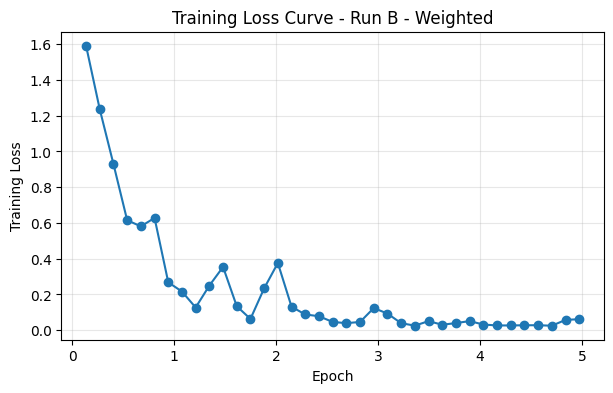

TypeError: Object of type int32 is not JSON serializable

In [14]:
overall_b, report_b, pred_output_b = evaluate_and_print(
    trainer_b, tokenized_datasets["dev"], "Run B - Weighted"
)
loss_curve_b = plot_training_loss(trainer_b, "Run B - Weighted")

run_b_final_dir = RUN_B_DIR / "final_model"
run_b_final_dir.mkdir(parents=True, exist_ok=True)
trainer_b.save_model(str(run_b_final_dir))
tokenizer.save_pretrained(str(run_b_final_dir))

(RUN_B_DIR / "dev_overall_metrics.json").write_text(
    json.dumps(overall_b, indent=2, ensure_ascii=False),
    encoding="utf-8",
)
(RUN_B_DIR / "dev_classification_report.json").write_text(
    json.dumps(report_b, indent=2, ensure_ascii=False),
    encoding="utf-8",
)
if not loss_curve_b.empty:
    loss_curve_b.to_csv(RUN_B_DIR / "training_loss_curve.csv", index=False)

print(f"Saved Run B model and metrics under: {RUN_B_DIR}")


## Interpreting Per-Entity Metrics

Use per-entity precision/recall/F1 with support counts in mind:
- High-support classes (especially SCHOLAR) are expected to be more stable.
- Very low-support classes (BOOK, HADITH_REF, some I- tags) can show volatile scores.
- If weighted loss helps, you usually see recall gains on rare classes, sometimes with a precision tradeoff.

In [15]:
comparison_df = pd.DataFrame(
    {
        "Run A (standard)": overall_a,
        "Run B (weighted)": overall_b,
    }
)
comparison_df

comparison_csv_path = ROOT / "models" / "islamic_ner_ablation_comparison.csv"
comparison_json_path = ROOT / "models" / "islamic_ner_ablation_comparison.json"

comparison_payload = {
    "model_name": model_name,
    "max_seq_length": MAX_SEQ_LENGTH,
    "run_a_output_dir": str(RUN_A_DIR),
    "run_b_output_dir": str(RUN_B_DIR),
    "run_a_overall": overall_a,
    "run_b_overall": overall_b,
    "class_weights_normalized": normalized_weights,
}

comparison_df.to_csv(comparison_csv_path)
comparison_json_path.write_text(
    json.dumps(comparison_payload, indent=2, ensure_ascii=False),
    encoding="utf-8",
)

print("Comparison table saved to:", comparison_csv_path)
print("Comparison summary saved to:", comparison_json_path)



Comparison table saved to: C:\Users\diaab\islamic-ner\models\islamic_ner_ablation_comparison.csv
Comparison summary saved to: C:\Users\diaab\islamic-ner\models\islamic_ner_ablation_comparison.json
